# Experiment

## Approach

1. Load preprocessed time series dataset.
2. Define feature bundles and lookback periods
3. Create 21 data sets for 7 feature bundle combinations and 3 lookback periods
4. Train 21 models and compare performance on validation set to choose final model
5. Evaluate performance of final model on test set against VIX, mean and naive models

## 1. Load preprocessed time series dataset.

In [100]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
# load data
df = pd.read_csv('data/features_target.csv')

# rename unnamed column to Date and set to index
df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df.set_index('Date', inplace=True)
df

,SP500,SP500 Log Returns,SP500 30 Day Volatility,SPX Put Call Ratio,SPX Put Volume,SPX Call Volume,Total SPX Options Volume,VIX,DJIA,NASDAQ,...,NASDAQ_log_returns,RUSSELL_log_returns,MSCI_World_log_returns,USD_Index_log_returns,Gold_log_returns,Oil_log_returns,SP500_put_log_change,SP500_call_log_change,SP500_total_opts_log_change,Consumer_Sentiment_log_change
Date,,,,,,,,,,,,,,,,,,,,,
2010-07-08,1070.25,0.009369,28.510976,1.12,280436.0,251021.0,531457.0,25.71,10138.99,2175.40,...,0.007350,0.013978,0.012148,0.000000,-0.002338,0.018862,-0.076998,-0.278034,-0.176999,0.000000
2010-07-09,1077.96,0.007178,28.462814,1.20,376805.0,315132.0,691937.0,24.98,10198.03,2196.45,...,0.009630,0.014660,0.006065,0.001550,0.011389,0.008183,0.295382,0.227455,0.263873,0.000000
2010-07-12,1078.75,0.000733,28.041079,1.49,421390.0,283127.0,704517.0,24.43,10216.27,2198.36,...,0.000869,-0.012502,0.000000,0.002974,-0.009217,-0.015231,0.111831,-0.107096,0.018018,0.000000
2010-07-13,1095.34,0.015262,28.157439,1.25,652349.0,519892.0,1172241.0,24.56,10363.02,2242.03,...,0.019670,0.033552,0.015906,-0.006673,0.012271,0.029327,0.437021,0.607726,0.509160,0.000000
2010-07-14,1095.17,-0.000155,28.338036,1.01,475499.0,469171.0,944670.0,24.89,10366.72,2249.84,...,0.003477,-0.004147,0.003690,-0.002514,-0.005371,-0.001816,-0.316215,-0.102654,-0.215837,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-30,2976.74,0.005035,47.065115,2.26,831789.0,368628.0,1200417.0,16.24,26916.83,7999.34,...,0.007492,0.001899,0.002066,0.002519,-0.022489,-0.033809,-0.428766,-0.404693,-0.421435,0.000000
2019-10-01,2940.25,-0.012334,46.781249,2.07,818005.0,395722.0,1213727.0,18.56,26573.04,7908.68,...,-0.011398,-0.019849,-0.009911,-0.002519,0.010872,-0.009100,-0.016710,0.070924,0.011027,0.024379
2019-10-02,2887.61,-0.018065,47.359805,1.82,1463102.0,804358.0,2267460.0,20.56,26078.62,7785.25,...,-0.015730,-0.009283,-0.017290,-0.001110,0.012613,-0.017503,0.581446,0.709332,0.624964,0.000000


## 2. Define feature bundles

In [3]:
df.columns

Index(['SP500', 'SP500 Log Returns', 'SP500 30 Day Volatility',
       'SPX Put Call Ratio', 'SPX Put Volume', 'SPX Call Volume',
       'Total SPX Options Volume', 'VIX', 'DJIA', 'NASDAQ', '10Y_Treasury',
       'High_Yield_Bonds', 'RUSSELL', 'EMB_Yield', 'MSCI_World',
       'Consumer_Sentiment', 'USD_Index', 'Gold', 'Oil', 'DJIA_log_returns',
       'NASDAQ_log_returns', 'RUSSELL_log_returns', 'MSCI_World_log_returns',
       'USD_Index_log_returns', 'Gold_log_returns', 'Oil_log_returns',
       'SP500_put_log_change', 'SP500_call_log_change',
       'SP500_total_opts_log_change', 'Consumer_Sentiment_log_change'],
      dtype='object')

In [4]:
sp500_bundle = ['SP500 30 Day Volatility','SP500', 'SP500 Log Returns', 'SPX Put Call Ratio',
       'SPX Put Volume', 'SPX Call Volume', 'Total SPX Options Volume', 'VIX','SP500_put_log_change', 'SP500_call_log_change',
       'SP500_total_opts_log_change']

financial_bundle = ['SP500 30 Day Volatility','DJIA', 'NASDAQ', '10Y_Treasury', 'High_Yield_Bonds', 'RUSSELL',
       'EMB_Yield', 'MSCI_World', 'DJIA_log_returns', 'NASDAQ_log_returns', 'RUSSELL_log_returns',
       'MSCI_World_log_returns']

economic_bundle = ['SP500 30 Day Volatility','Consumer_Sentiment', 'USD_Index', 'Gold',
       'Oil', 'USD_Index_log_returns', 'Gold_log_returns',
       'Oil_log_returns','Consumer_Sentiment_log_change']

len(sp500_bundle), len(financial_bundle), len(economic_bundle)

(11, 12, 9)

## 3 Create 21 data sets for 7 feature bundle combinations and 3 lookback periods


In [5]:
# create powerset of bundles

from utils import powerset
from itertools import chain

bundle_combinations = powerset([sp500_bundle, financial_bundle, economic_bundle])

# drop empty set
bundle_combinations = bundle_combinations[1:]

# flatten list of lists
bundle_combinations = [list(chain.from_iterable(x)) for x in bundle_combinations]

# drop duplicates in elements of list

bundle_combinations = [list(set(x)) for x in bundle_combinations]

# make SP500 30 Day Volatility last element of each list

for i in range(len(bundle_combinations)):
    bundle_combinations[i].remove('SP500 30 Day Volatility')
    bundle_combinations[i].append('SP500 30 Day Volatility')

bundle_combinations[-1]

['Oil_log_returns',
 'Total SPX Options Volume',
 'NASDAQ',
 'SP500_put_log_change',
 'SP500_total_opts_log_change',
 '10Y_Treasury',
 'Consumer_Sentiment',
 'NASDAQ_log_returns',
 'Oil',
 'SP500_call_log_change',
 'DJIA',
 'SPX Call Volume',
 'Gold',
 'SP500',
 'DJIA_log_returns',
 'USD_Index_log_returns',
 'USD_Index',
 'VIX',
 'Consumer_Sentiment_log_change',
 'RUSSELL',
 'SPX Put Volume',
 'RUSSELL_log_returns',
 'MSCI_World_log_returns',
 'SP500 Log Returns',
 'Gold_log_returns',
 'EMB_Yield',
 'High_Yield_Bonds',
 'MSCI_World',
 'SPX Put Call Ratio',
 'SP500 30 Day Volatility']

In [55]:
# pickle bundle_combinations

import pickle

with open('data/bundle_combinations.pkl', 'wb') as f:
    pickle.dump(bundle_combinations, f)

In [6]:
# define lookback periods

lookback_periods = [50, 100, 200]

# define predict_ahead as 30

predict_ahead = 30

# define train, val, test sizes

train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.15)
test_size = len(df) - train_size - val_size

val_perc = 0.15
test_perc = 0.15

# create list of datasets for each bundle combination and lookback period

from utils import create_dataset
from utils import train_val_test_split

datasets = []

for bundle in bundle_combinations:
    for lookback in lookback_periods:
        df_bundle = df[bundle]
        print(df_bundle)
        dataset = df_bundle.values
        #print(dataset)
        dataset = dataset.astype('float32')
        X, Y = create_dataset(dataset, lookback, predict_ahead, -1)
        X_train, Y_train, X_val, Y_val, X_test, Y_test = train_val_test_split(X, Y, val_perc, test_perc, dataset.shape[0])
        print(Y_train.shape, Y_val.shape, Y_test.shape)
        datasets.append((X_train, Y_train, X_val, Y_val, X_test, Y_test, bundle, lookback))

datasets[0][0].shape, datasets[0][-1]

            SPX Put Volume  Total SPX Options Volume  SP500_call_log_change  \
Date                                                                          
2010-07-08        280436.0                  531457.0              -0.278034   
2010-07-09        376805.0                  691937.0               0.227455   
2010-07-12        421390.0                  704517.0              -0.107096   
2010-07-13        652349.0                 1172241.0               0.607726   
2010-07-14        475499.0                  944670.0              -0.102654   
...                    ...                       ...                    ...   
2019-09-30        831789.0                 1200417.0              -0.404693   
2019-10-01        818005.0                 1213727.0               0.070924   
2019-10-02       1463102.0                 2267460.0               0.709332   
2019-10-03       1094088.0                 1547116.0              -0.574091   
2019-10-04       1015727.0                 1453483.0

((1506, 50, 11), 50)

In [7]:
len(datasets[0])

8

In [81]:
# create list of dataset names for each bundle combination and lookback period where dataset name is bundles + lookback

# S = S&P500 bundle, F = Financial bundle, E = Economic bundle

dataset_names = []

bundle_codes = ['S', 'F', 'E']

# create powerset of bundle codes

bundle_code_combinations = powerset(bundle_codes)

# drop empty set
bundle_code_combinations = bundle_code_combinations[1:]

# turn tuples into strings

bundle_code_combinations = ["".join(x) for x in bundle_code_combinations]

# add lookback periods to each string

for i in range(len(bundle_code_combinations)):
    for lookback in lookback_periods:
        dataset_names.append(bundle_code_combinations[i] + str(lookback))

dataset_names

['S50',
 'S100',
 'S200',
 'F50',
 'F100',
 'F200',
 'E50',
 'E100',
 'E200',
 'SF50',
 'SF100',
 'SF200',
 'SE50',
 'SE100',
 'SE200',
 'FE50',
 'FE100',
 'FE200',
 'SFE50',
 'SFE100',
 'SFE200']

## 4 Train 21 models and compare performance on validation set to choose final model

In [8]:
 # define lstm architecture

from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

# import tqdm for progress bar

from tqdm.notebook import tqdm

# define number of trials for each dataset

n_trials = 30


# train model on each dataset and append results to list

for idx, dataset in tqdm(enumerate(datasets)):
    
    X_train, Y_train, X_val, Y_val, X_test, Y_test, bundle, lookback = dataset
    
    model = Sequential([layers.Input((lookback, len(bundle))),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

    model.compile(loss='mse', 
                optimizer=Adam(learning_rate=0.001),
                metrics=['mean_absolute_error'])
    
    val_pred_list = []

    for i in range(n_trials):

        model.fit(X_train, Y_train, epochs=25, validation_data=(X_val, Y_val), verbose=0)
        val_predictions = model.predict(X_val).flatten()
        val_pred_list.append(val_predictions)
    
    # add val_predictions to dataset tuple
    datasets[idx] = dataset + (model, val_pred_list,)
    

2023-07-18 19:48:07.848465: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


0it [00:00, ?it/s]

2023-07-18 19:48:10.671295: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


11/11 [==============================] - 0s 21ms/step


In [118]:
# print model summary

model.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_20 (LSTM)              (None, 64)                24320     
                                                                 
 dense_60 (Dense)            (None, 32)                2080      
                                                                 
 dense_61 (Dense)            (None, 32)                1056      
                                                                 
 dense_62 (Dense)            (None, 1)                 33        
                                                                 
Total params: 27,489
Trainable params: 27,489
Non-trainable params: 0
_________________________________________________________________


In [9]:
# calculate MAE for each dataset

from sklearn.metrics import mean_absolute_error

for idx, dataset in tqdm(enumerate(datasets)):
    X_train, Y_train, X_val, Y_val, X_test, Y_test, bundle, lookback, model, val_pred_list = dataset

    maes = []

    for val_predictions in val_pred_list:
        mae = mean_absolute_error(Y_val, val_predictions)
        maes.append(mae)
    
    datasets[idx] = dataset + (maes,)

0it [00:00, ?it/s]

In [11]:
dataset[0][-1]

array([[ 1.3366318 ,  2.9954162 ,  1.1171854 , ...,  0.40446627,
         0.07419408,  2.4275353 ],
       [-2.890493  ,  2.5022542 ,  0.9776147 , ...,  0.27345958,
         1.2392963 ,  2.7947931 ],
       [-4.8693233 ,  4.9655514 ,  0.9580022 , ...,  0.13673076,
         1.504447  ,  3.4363627 ],
       ...,
       [-1.2737448 ,  1.490962  ,  1.2884158 , ...,  0.74306273,
        -0.31786305, -0.7618487 ],
       [-0.62591815,  1.9228903 ,  1.2344328 , ...,  0.7133188 ,
         0.3002733 , -0.6333814 ],
       [-0.5639228 ,  2.8018925 ,  1.2193073 , ...,  0.6781813 ,
         0.6090385 , -0.47815067]], dtype=float32)

Dataset Name: S50 , Mean Validation MAE: 29.2521 , Standard Deviation Validation MAE: 3.077575 , Bundle: ['SPX Put Volume', 'Total SPX Options Volume', 'SP500_call_log_change', 'SP500_put_log_change', 'SP500 Log Returns', 'SPX Call Volume', 'SP500_total_opts_log_change', 'SP500', 'VIX', 'SPX Put Call Ratio', 'SP500 30 Day Volatility'] , Lookback: 50
Dataset Name: S100 , Mean Validation MAE: 21.671976 , Standard Deviation Validation MAE: 2.441632 , Bundle: ['SPX Put Volume', 'Total SPX Options Volume', 'SP500_call_log_change', 'SP500_put_log_change', 'SP500 Log Returns', 'SPX Call Volume', 'SP500_total_opts_log_change', 'SP500', 'VIX', 'SPX Put Call Ratio', 'SP500 30 Day Volatility'] , Lookback: 100
Dataset Name: S200 , Mean Validation MAE: 17.34649 , Standard Deviation Validation MAE: 0.65110624 , Bundle: ['SPX Put Volume', 'Total SPX Options Volume', 'SP500_call_log_change', 'SP500_put_log_change', 'SP500 Log Returns', 'SPX Call Volume', 'SP500_total_opts_log_change', 'SP500', 'VIX', 

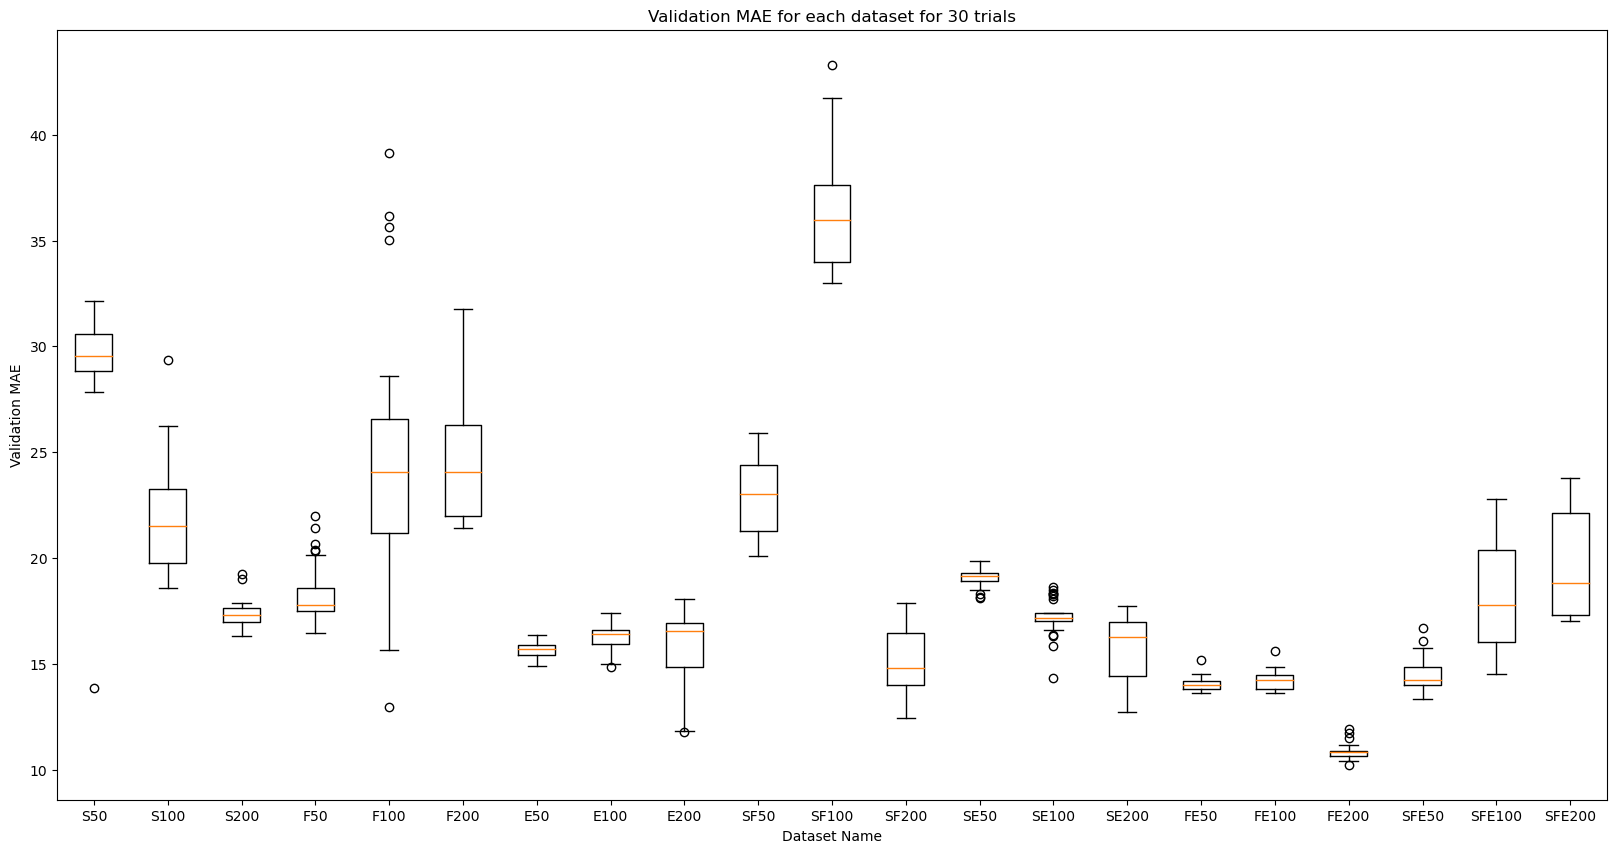

In [83]:
# print mean MAE and standard deviation for each dataset

for idx, dataset in enumerate(datasets):
    print('Dataset Name:', dataset_names[idx], ', Mean Validation MAE:', np.mean(dataset[-1]), ', Standard Deviation Validation MAE:', np.std(dataset[-1]), ', Bundle:', dataset[6], ', Lookback:', dataset[7])

# plot boxplot of MAE list for each dataset

mae_lists = [dataset[-1] for dataset in datasets]


# turn list of lists into df with each list as a column

#mae_lists = pd.DataFrame(mae_lists).T
print(mae_lists)

plt.figure(figsize=(20,10))
plt.boxplot(mae_lists)
plt.xticks(np.arange(1, len(mae_lists)+1), dataset_names)
plt.xlabel('Dataset Name')
plt.ylabel('Validation MAE')
plt.title(f'Validation MAE for each dataset for {n_trials} trials')
plt.show()


FE200 performs the best with a mean validation MAE of 10.87. Looking at the boxplots above it becomes apparant that it consistently outperformed all other models.


[[13.863033, 28.375887, 32.061012, 30.581005, 31.083376, 31.687592, 32.127228, 31.126722, 30.79415, 30.50749, 30.665565, 30.175983, 30.482653, 29.709183, 29.53099, 29.400229, 29.021288, 29.434885, 30.371826, 29.214512, 29.58648, 29.62591, 29.08928, 29.0404, 28.805298, 28.47086, 28.308773, 28.265083, 28.310072, 27.846176], [29.36562, 25.09813, 23.989681, 26.254007, 23.513994, 22.437714, 21.932789, 21.579435, 21.452982, 22.303143, 21.713562, 21.988861, 23.672401, 23.949411, 23.570234, 21.564342, 21.169989, 21.045677, 20.393017, 20.571768, 19.999565, 19.997032, 19.72366, 18.80554, 19.31861, 19.317568, 18.88646, 19.27211, 18.670826, 18.601213], [19.25106, 19.035425, 17.503613, 17.297474, 17.489445, 17.84485, 17.654886, 17.891022, 17.648273, 17.826864, 17.32677, 17.44858, 17.787045, 17.186329, 17.619791, 17.593517, 17.289848, 17.059195, 17.358572, 17.232698, 17.1407, 16.939974, 16.68502, 16.629274, 16.460123, 16.594, 17.070854, 16.706766, 16.315798, 16.506933], [18.235748, 16.474434, 21.973

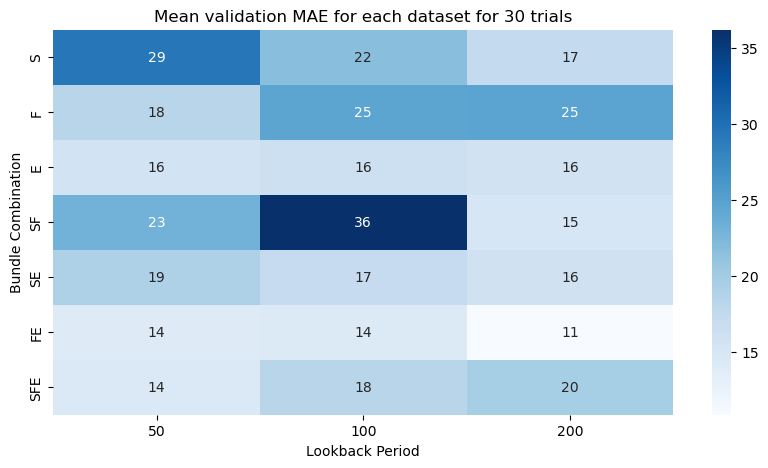

In [113]:
# create table with feature bundle as row and lookback period as column and value as mean MAE

print(mae_lists)

# calculate mean MAE for each dataset

mean_maes = [np.mean(dataset[-1]) for dataset in datasets] 
mean_maes = np.array(mean_maes).reshape(len(bundle_combinations), len(lookback_periods))
print(mean_maes.shape)
print(len(bundle_code_combinations))

# create df with mean MAE for each dataset

mean_maes_df = pd.DataFrame(mean_maes, columns=lookback_periods, index=bundle_code_combinations)

# plot heatmap of mean MAE for each dataset

plt.figure(figsize=(10,5))
sns.heatmap(mean_maes_df, annot=True, cmap='Blues')
plt.xlabel('Lookback Period')
plt.ylabel('Bundle Combination')
plt.title(f'Mean validation MAE for each dataset for {n_trials} trials')
plt.show()

(7, 3)
7


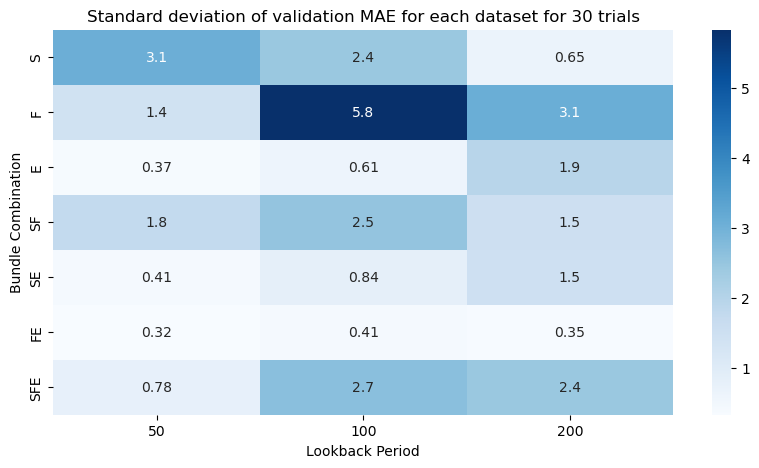

In [114]:
# same for standard deviation


std_maes = [np.std(dataset[-1]) for dataset in datasets] 
std_maes = np.array(std_maes).reshape(len(bundle_combinations), len(lookback_periods))
print(std_maes.shape)
print(len(bundle_code_combinations))

# create df with mean MAE for each dataset

std_maes_df = pd.DataFrame(std_maes, columns=lookback_periods, index=bundle_code_combinations)

# plot heatmap of mean MAE for each dataset

plt.figure(figsize=(10,5))
sns.heatmap(std_maes_df, annot=True, cmap='Blues')
plt.xlabel('Lookback Period')
plt.ylabel('Bundle Combination')
plt.title(f'Standard deviation of validation MAE for each dataset for {n_trials} trials')
plt.show()

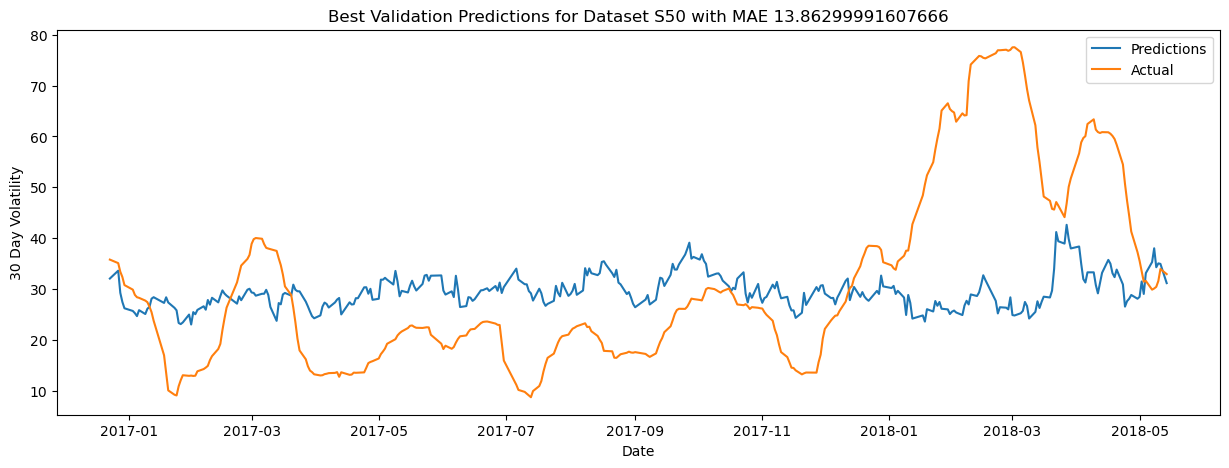

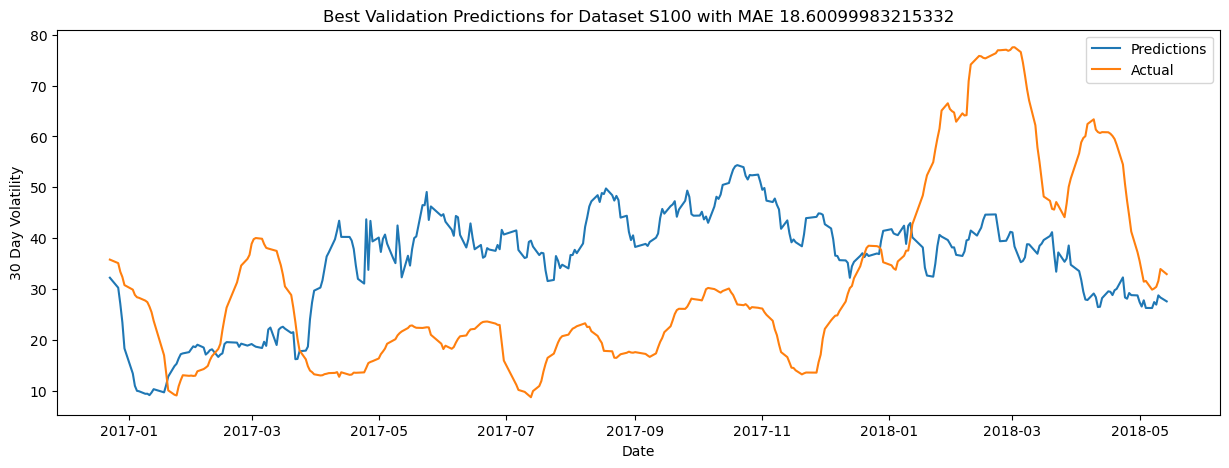

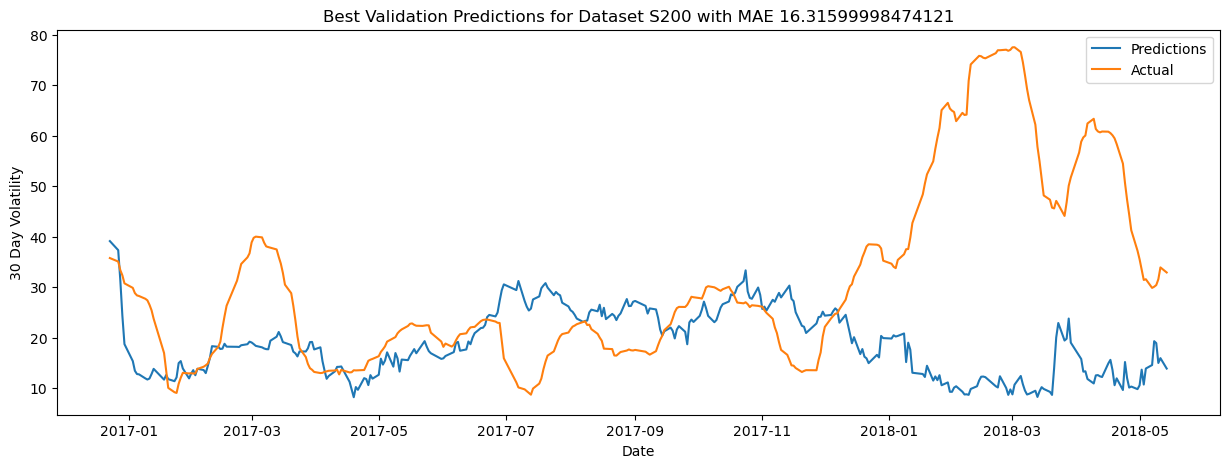

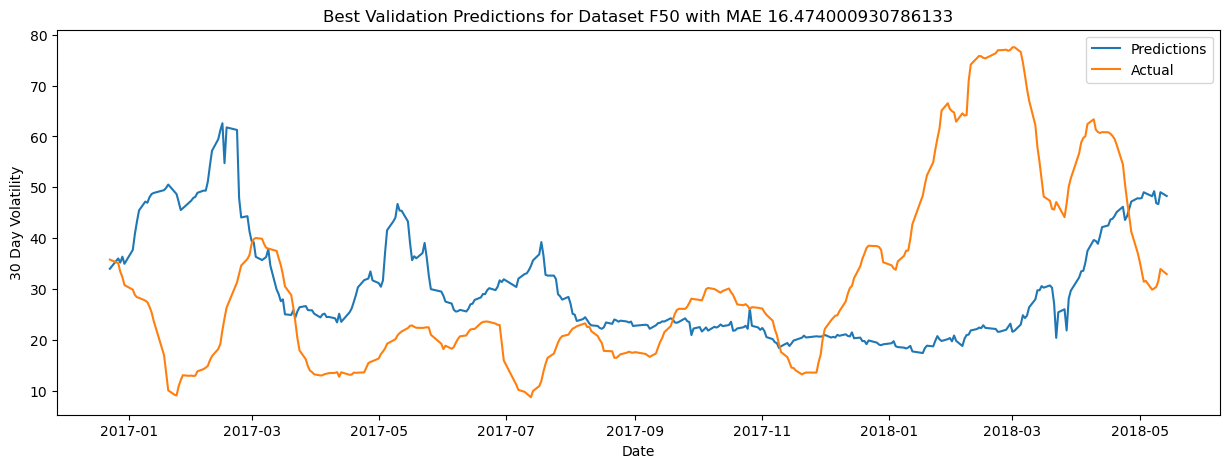

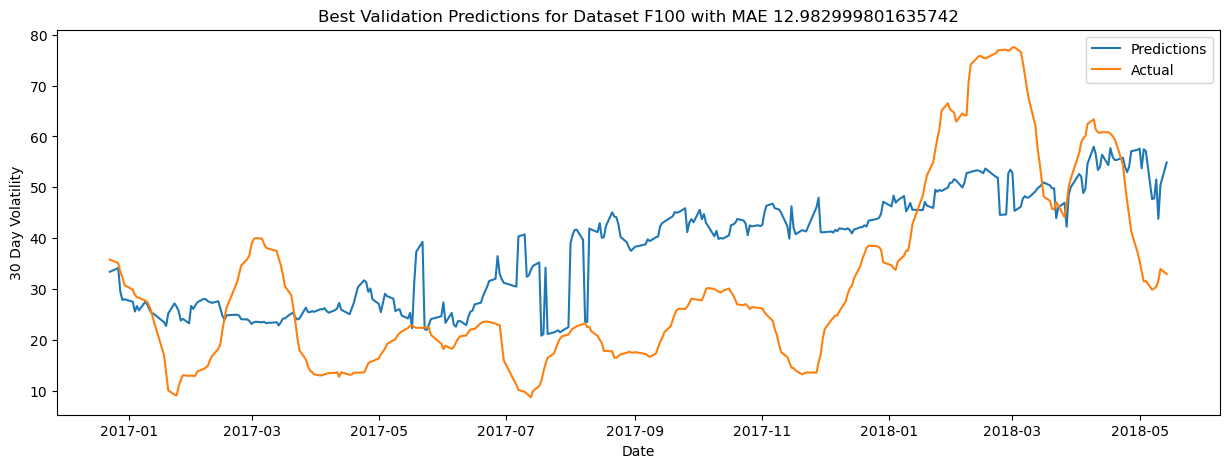

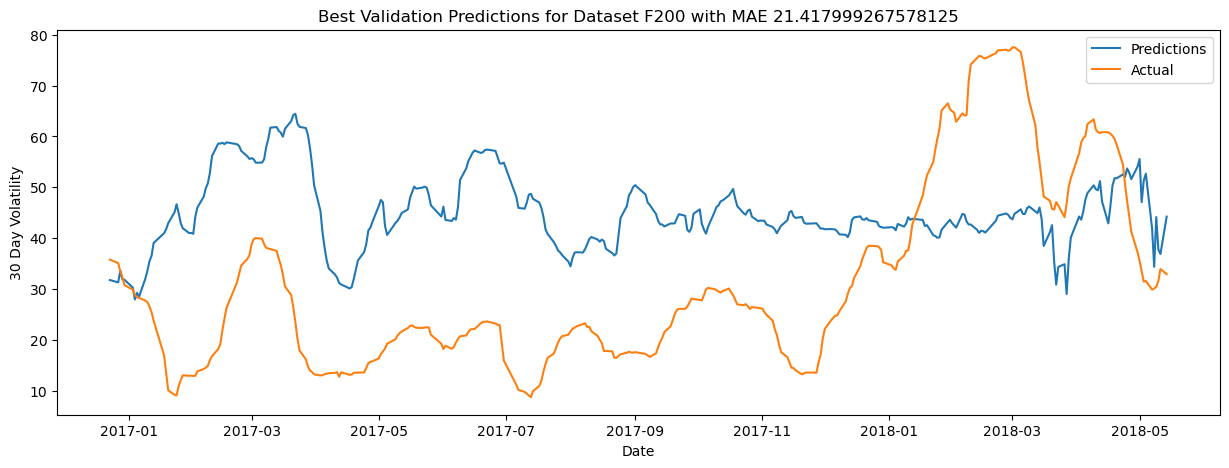

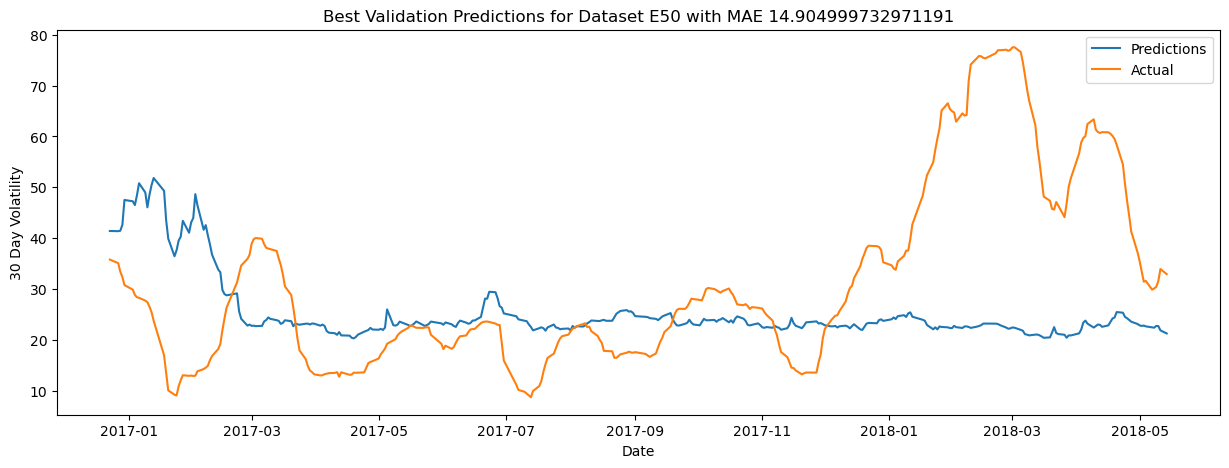

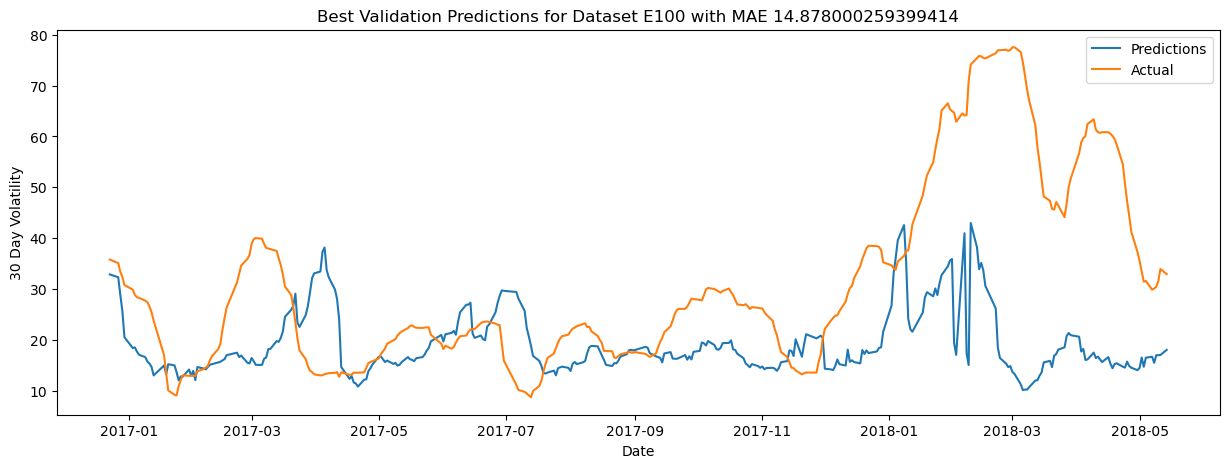

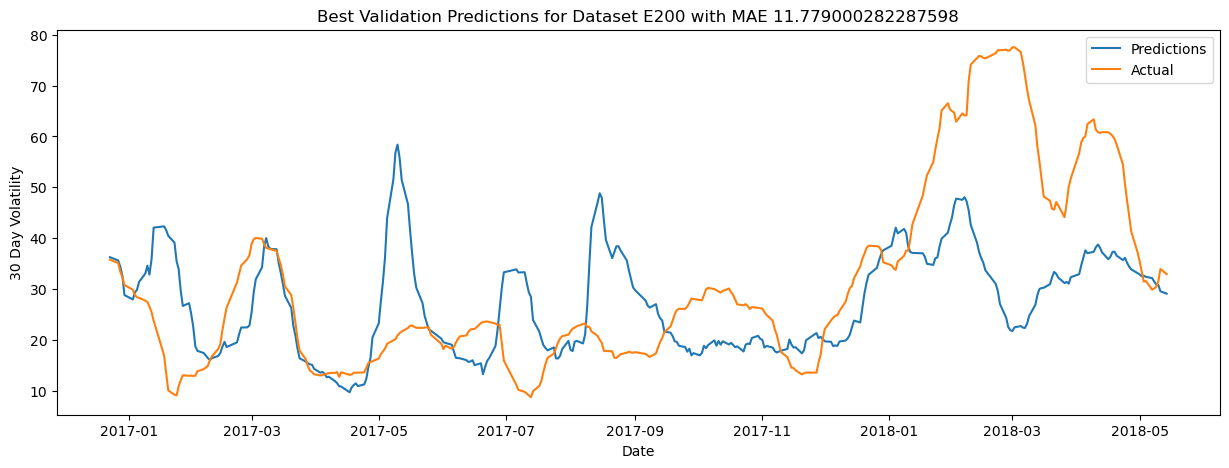

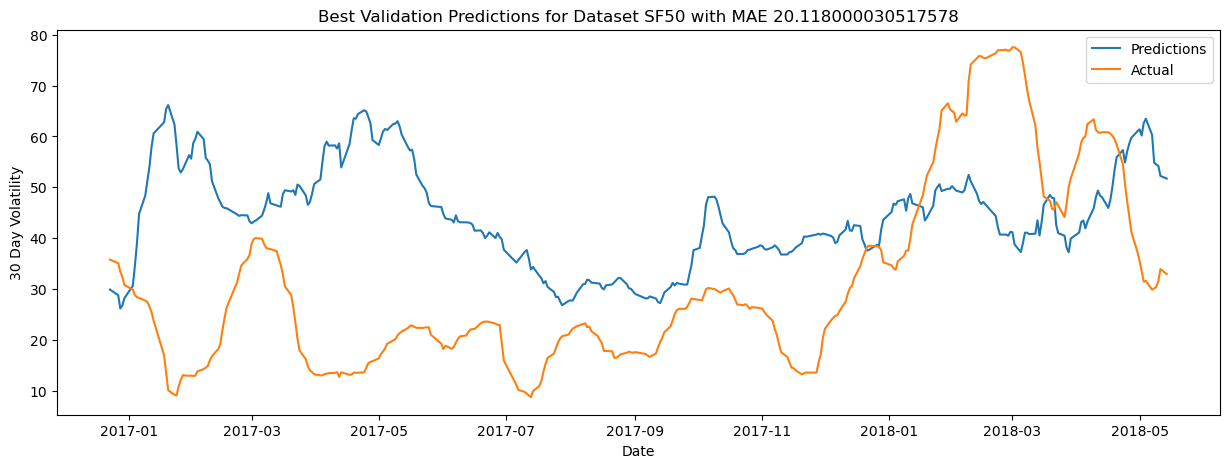

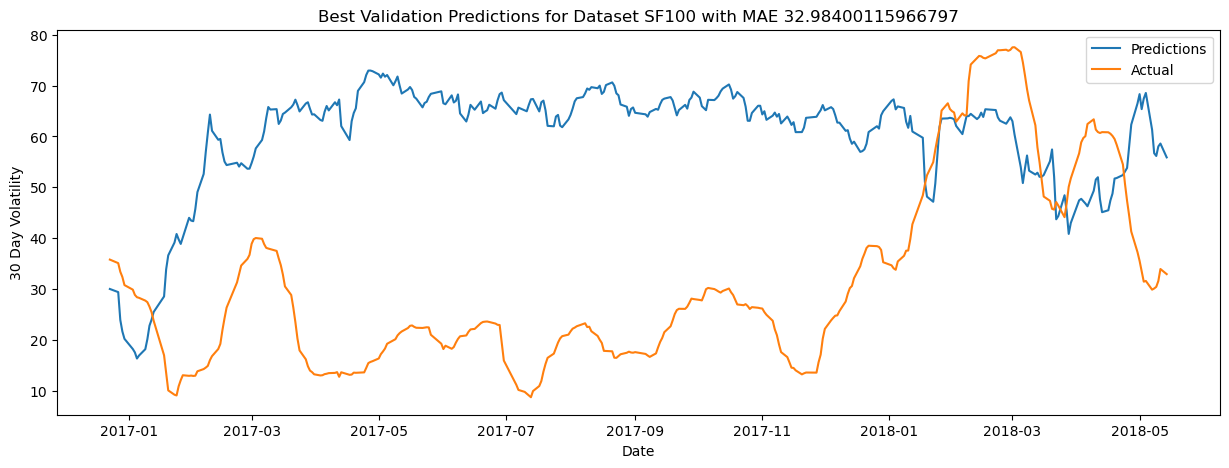

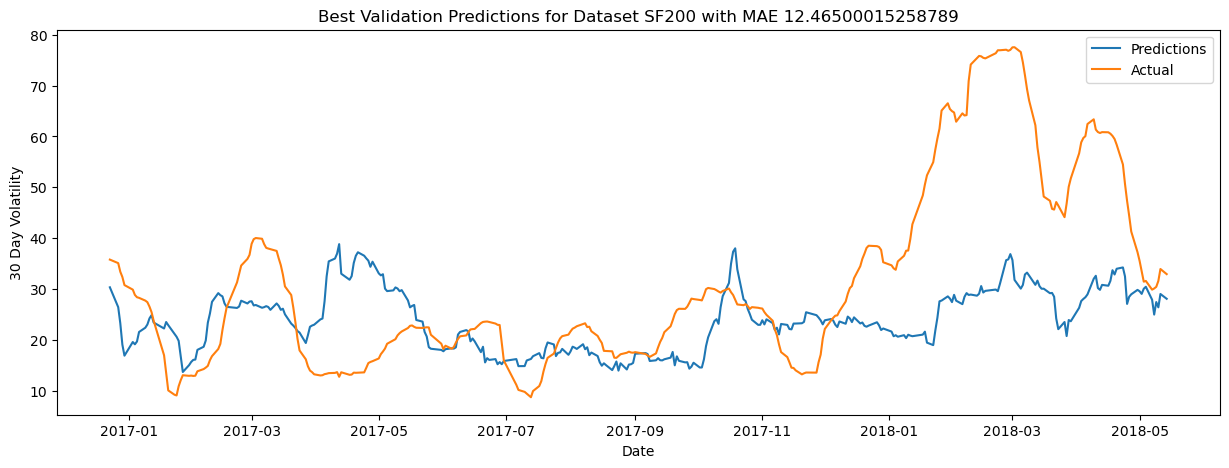

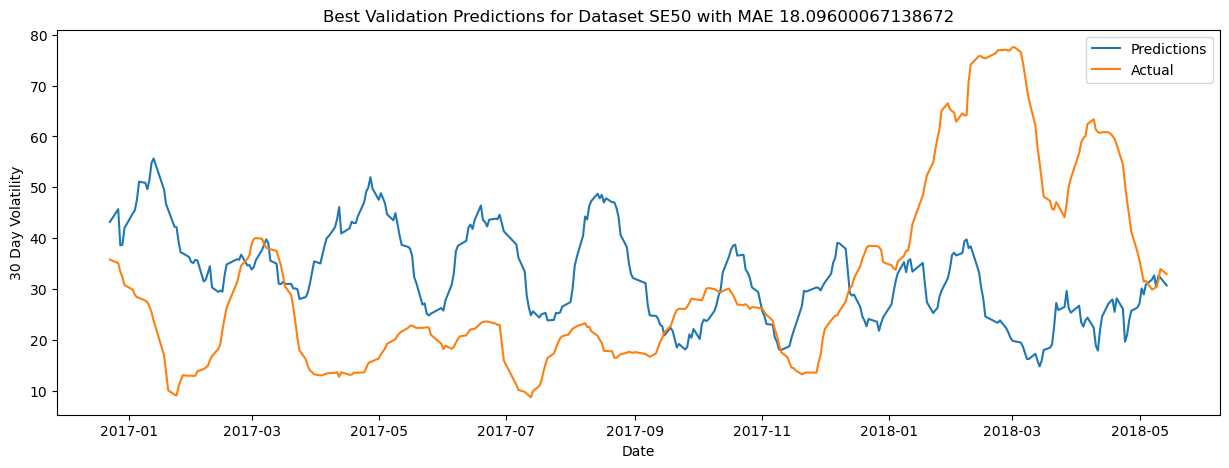

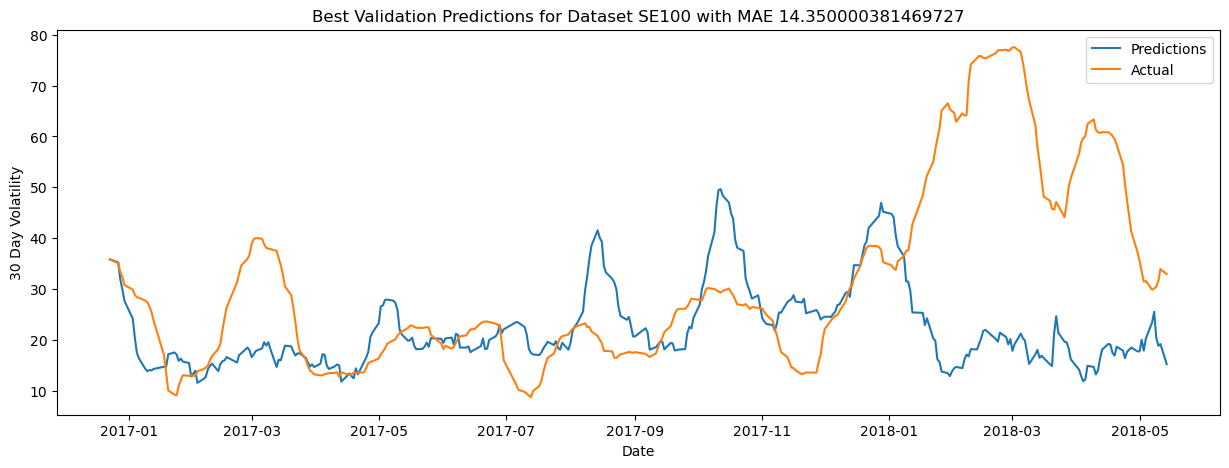

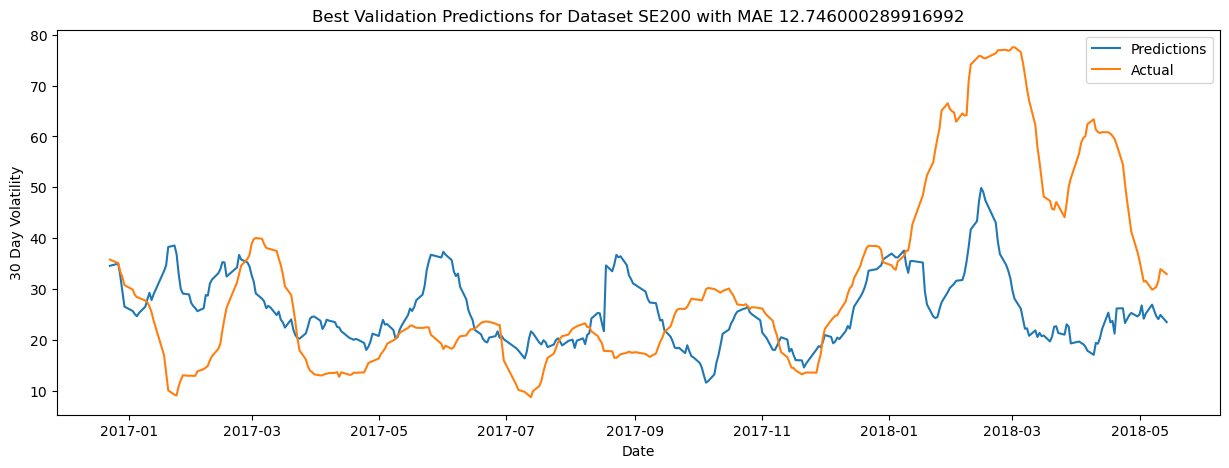

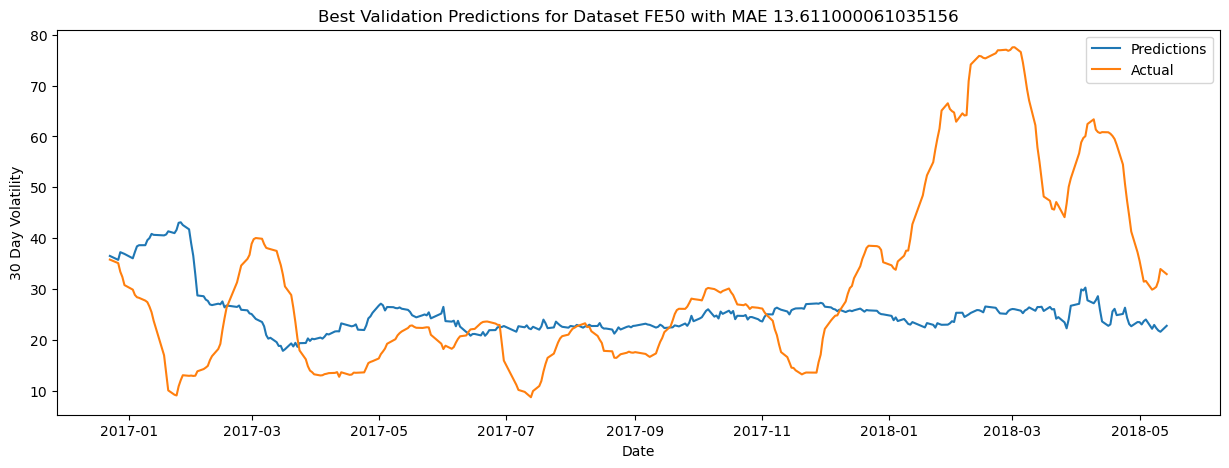

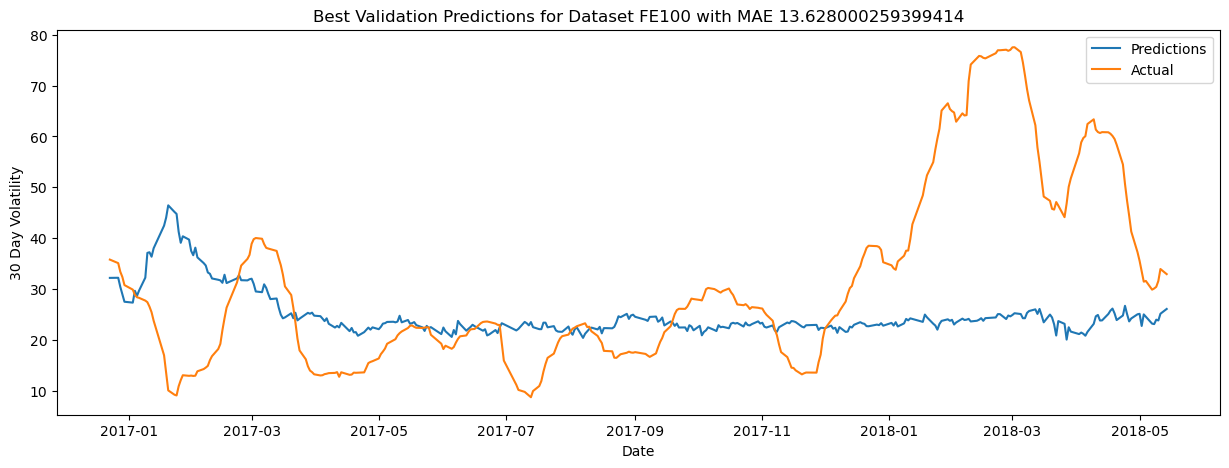

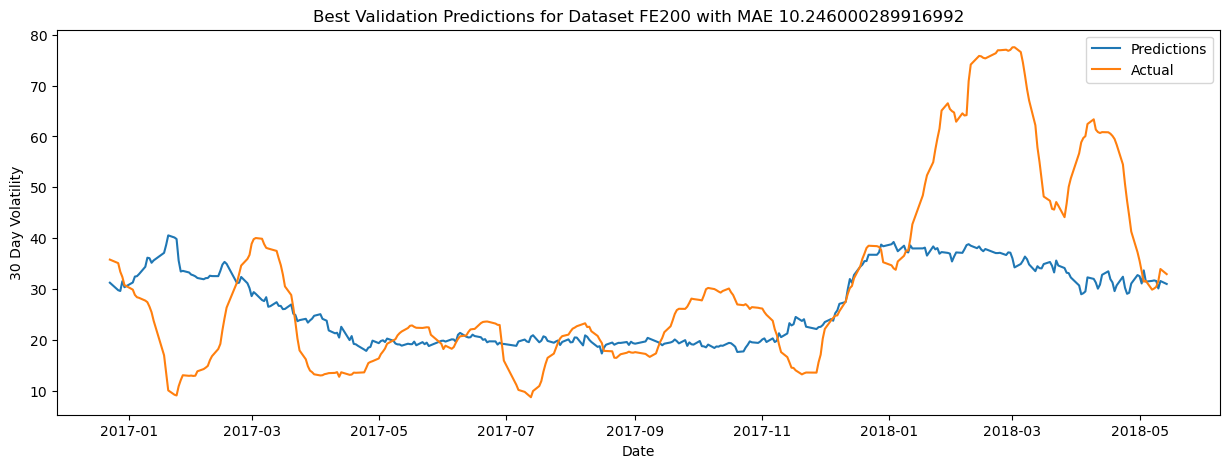

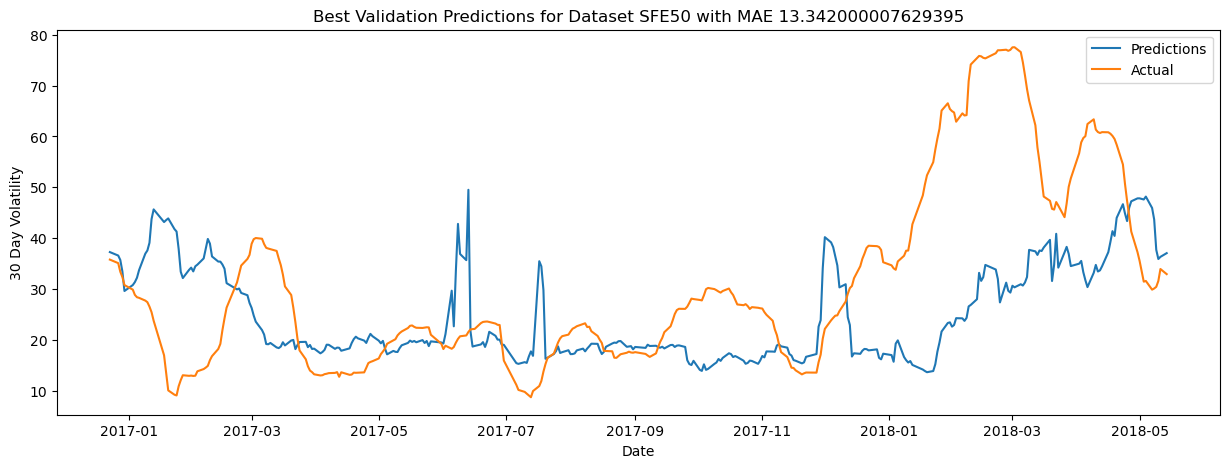

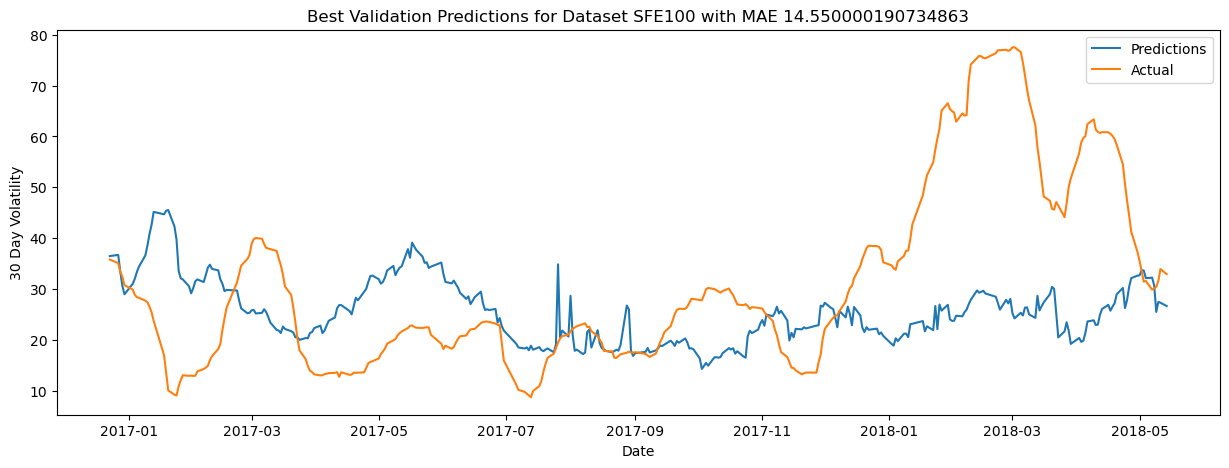

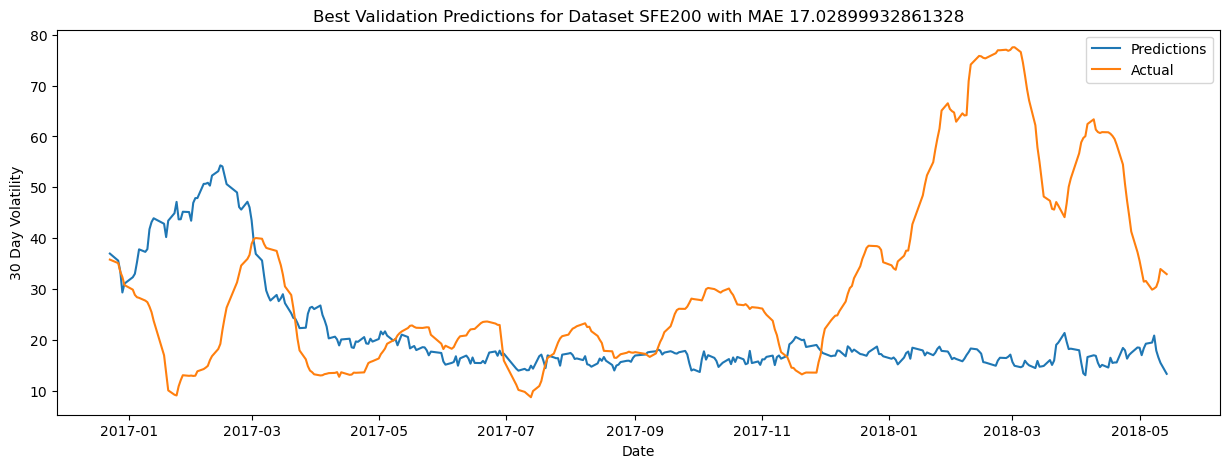

In [104]:
# get date range from df index for validation set
dates = list(df.index)
start_idx = len(dates) - len(Y_val) - len(Y_test)
stop_idx = len(dates) - len(Y_test)

val_dates = dates[start_idx:stop_idx]

# change val_dates to datetime

val_dates = pd.to_datetime(val_dates)


# plot validation predictions for each dataset and real 30 day volatility

for idx, dataset in enumerate(datasets):
    X_train, Y_train, X_val, Y_val, X_test, Y_test, bundle, lookback, model, val_predictions, mae_list = dataset

    # find index of lowest MAE
    min_mae_idx = np.argmin(mae_list)
    val_predictions = val_predictions[min_mae_idx]
    plt.figure(figsize=(15,5))
    plt.plot(val_dates, val_predictions, label='Predictions')
    plt.plot(val_dates, Y_val, label='Actual')
    plt.title(f'Best Validation Predictions for Dataset {dataset_names[idx]} with MAE {round(min(mae_list), 3)}')
    plt.xlabel('Date')
    plt.ylabel('30 Day Volatility')
    plt.legend()
    plt.show()

In [22]:
# print bundle and lookback for dataset 17

print(datasets[17][6], datasets[17][7])

['Oil_log_returns', 'NASDAQ', '10Y_Treasury', 'Consumer_Sentiment', 'NASDAQ_log_returns', 'Oil', 'DJIA', 'Gold', 'DJIA_log_returns', 'USD_Index_log_returns', 'USD_Index', 'Consumer_Sentiment_log_change', 'RUSSELL', 'RUSSELL_log_returns', 'MSCI_World_log_returns', 'Gold_log_returns', 'EMB_Yield', 'High_Yield_Bonds', 'MSCI_World', 'SP500 30 Day Volatility'] 200



Model FE200 with the economics and financial feature bundle and a lookback period of 200 trading days seems to perform the best on the validation period.

How does it compare to the VIX for the same timeframe?

VIX Baseline MAE: 18.4049440580835


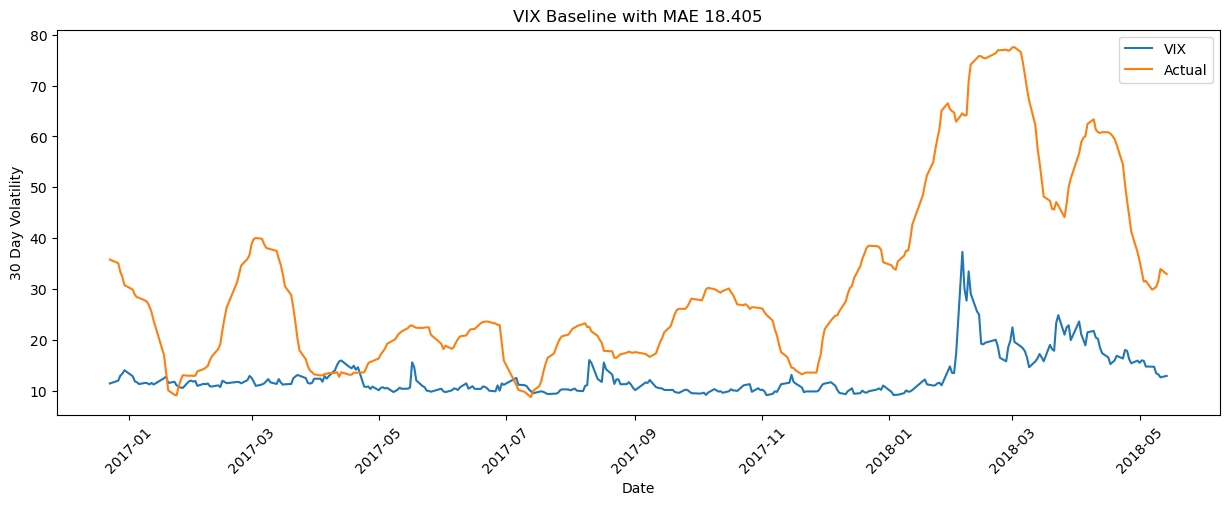

In [115]:
# calculate MAE for VIX baseline

vix_mae = mean_absolute_error(Y_val, df['VIX'][start_idx:stop_idx])
print('VIX Baseline MAE:', vix_mae)

# plot VIX baseline

plt.figure(figsize=(15,5))
plt.plot(val_dates, df['VIX'][start_idx:stop_idx], label='VIX')
plt.plot(val_dates, Y_val, label='Actual')
plt.title(f'VIX Baseline with MAE {round(vix_mae, 3)}')
plt.xlabel('Date')
plt.ylabel('30 Day Volatility')
plt.xticks(rotation=45)
plt.legend()
plt.show()

INFO:tensorflow:Assets written to: models/best_model/assets


INFO:tensorflow:Assets written to: models/best_model/assets


11/11 [==============================] - 0s 20ms/step
Test MAE for Best Model: 18.623732
Test MAE for VIX Baseline: 33.83961941676858


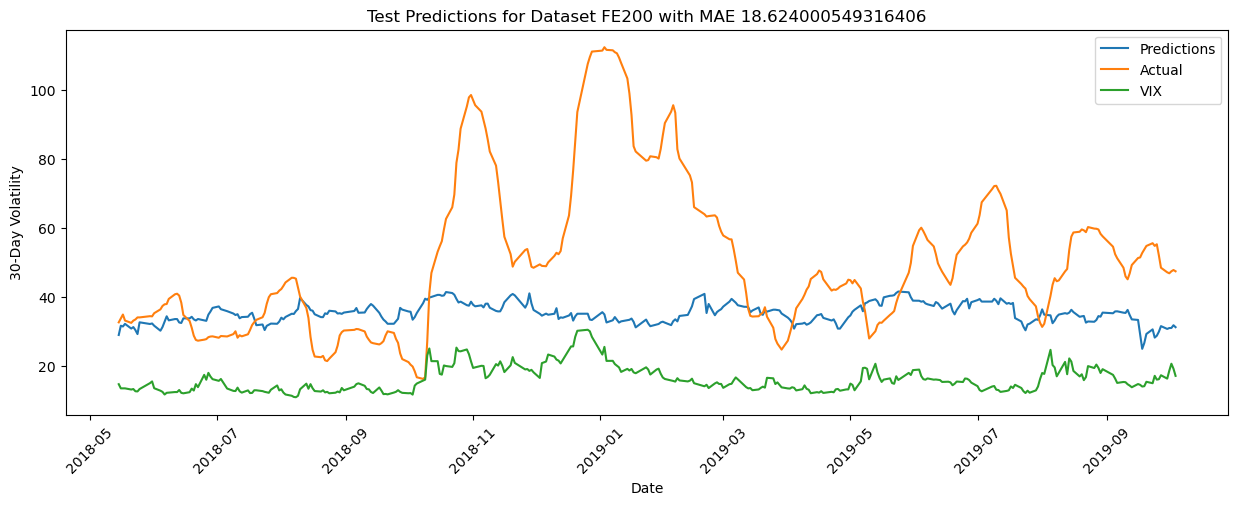

In [125]:
# compare predictions for test set for best model and VIX baseline

best_id = 17

best_model = datasets[best_id][-3]

# set working directory to volatility_prediction folder

os.chdir('/Users/mathisjander/wwu_master/DS4/Paper/volatility_prediction')

# save best model

best_model.save('models/best_model')

# save best model X_train, Y_train, X_val, Y_val, X_test, Y_test

X_train = datasets[best_id][0]
Y_train = datasets[best_id][1]

X_val = datasets[best_id][2]
Y_val = datasets[best_id][3]

X_test = datasets[best_id][4]
Y_test = datasets[best_id][5]

with open('data/best_model_data.pkl', 'wb') as f:
    pickle.dump((X_train, Y_train, X_val, Y_val, X_test, Y_test), f)

test_predictions = best_model.predict(X_test).flatten()

test_mae = mean_absolute_error(Y_test, test_predictions)
vix_mae = mean_absolute_error(Y_test, df['VIX'][stop_idx:])
print('Test MAE for Best Model:', test_mae)
print('Test MAE for VIX Baseline:', vix_mae)

# plot test predictions for best model and VIX baseline

test_dates = dates[stop_idx:]

test_dates = pd.to_datetime(test_dates)

plt.figure(figsize=(15,5))
plt.plot(test_dates, test_predictions, label='Predictions')
plt.plot(test_dates, Y_test, label='Actual')
plt.plot(test_dates, df['VIX'][stop_idx:], label='VIX')
plt.title(f'Test Predictions for Dataset {dataset_names[best_id]} with MAE {round(test_mae, 3)}')
plt.xlabel('Date')
plt.ylabel('30-Day Volatility')
plt.xticks(rotation=45)
plt.legend()
plt.show()




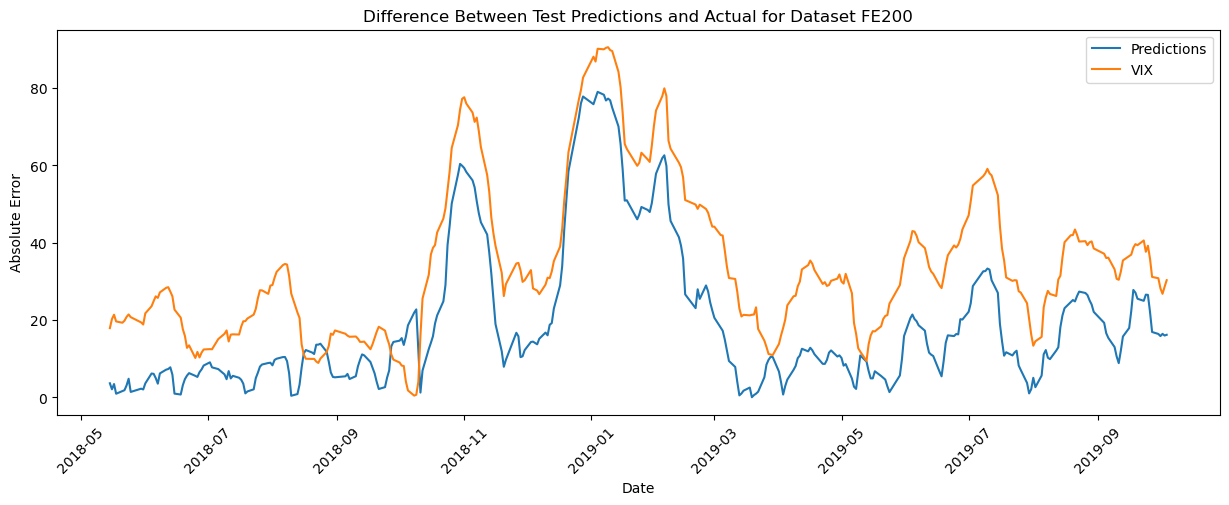

In [126]:
# plot difference between test predictions and actual for best model and VIX baseline

plt.figure(figsize=(15,5))
plt.plot(test_dates, abs(test_predictions - Y_test), label='Predictions')
plt.plot(test_dates, abs(df['VIX'][stop_idx:] - Y_test), label='VIX')
plt.title(f'Difference Between Test Predictions and Actual for Dataset {dataset_names[best_id]}')
plt.xlabel('Date')
plt.ylabel('Absolute Error')
plt.xticks(rotation=45)
plt.legend()
plt.show()


Looking at the graph above, the model has smaller absolute errors than the VIX baseline most of the time.

Test MAPE for Best Model: 32.59274661540985
Test MAPE for VIX Baseline: 63.8413190792263


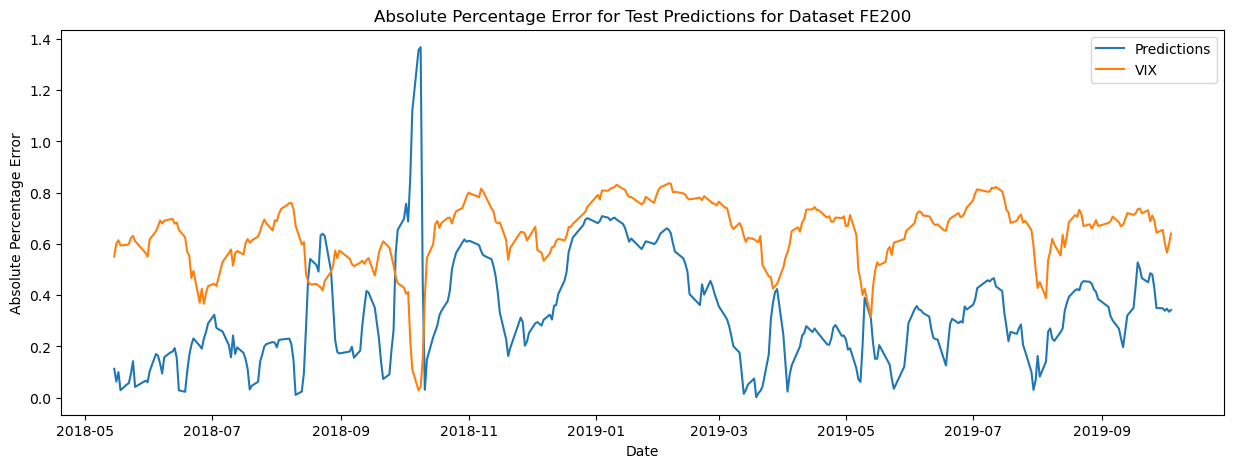

In [127]:
# plot MAPE for test predictions for best model and VIX baseline

def mean_absolute_percentage_error(y_true, y_pred):

    y_true, y_pred = np.array(y_true), np.array(y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

test_mape = mean_absolute_percentage_error(Y_test, test_predictions)
vix_mape = mean_absolute_percentage_error(Y_test, df['VIX'][stop_idx:])
print('Test MAPE for Best Model:', test_mape)
print('Test MAPE for VIX Baseline:', vix_mape)

plt.figure(figsize=(15,5))
plt.plot(test_dates, abs(test_predictions - Y_test) / Y_test, label='Predictions')
plt.plot(test_dates, abs(df['VIX'][stop_idx:] - Y_test) / Y_test, label='VIX')
plt.title(f'Absolute Percentage Error for Test Predictions for Dataset {dataset_names[best_id]}')
plt.xlabel('Date')
plt.ylabel('Absolute Percentage Error')
plt.legend()
plt.show()

Looking at the absolute percentage error (MAPE), the model has smaller errors than the VIX baseline most of the time.There some phases of substantially smaller errors than the VIX baseline, but only one short phase of substantially larger errors in October 2018.

Test MAE for Mean Model: 22.28177
Test MAE for Best Model: 18.623732


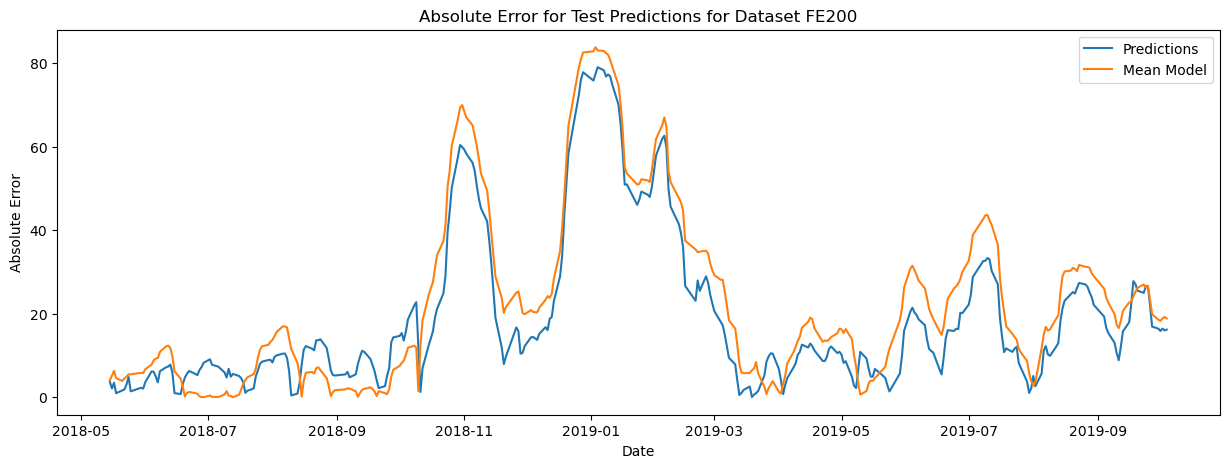

In [139]:
# compare predictions of best model on test set to simple model predicting average value during training

# get average value during training

avg_val = np.mean(Y_train)

# get MAE for simple model

simple_mean_mae = mean_absolute_error(Y_test, np.full(len(Y_test), avg_val))
print('Test MAE for Mean Model:', simple_mean_mae)
print('Test MAE for Best Model:', test_mae)

# plot simple model absolute error against best model absolute error

plt.figure(figsize=(15,5))
plt.plot(test_dates, abs(test_predictions - Y_test), label='Predictions')
plt.plot(test_dates, abs(np.full(len(Y_test), avg_val) - Y_test), label='Mean Model')
plt.title(f'Absolute Error for Test Predictions for Dataset {dataset_names[best_id]}')
plt.xlabel('Date')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()

Test MAPE for Mean Model: 36.902135610580444
Test MAPE for Best Model: 32.59274661540985


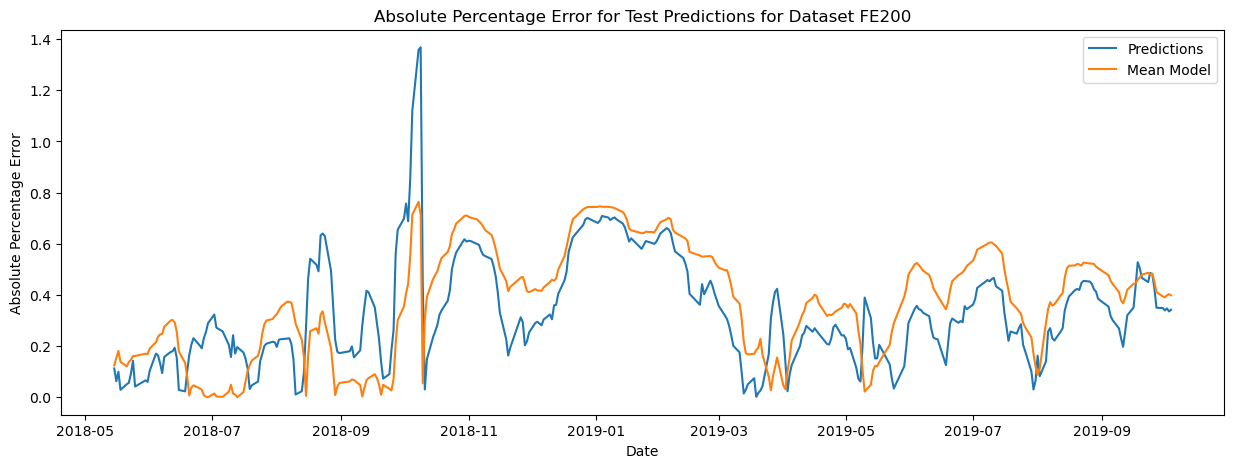

In [140]:
# same for MAPE

simple_mean_mape = mean_absolute_percentage_error(Y_test, np.full(len(Y_test), avg_val))
print('Test MAPE for Mean Model:', simple_mean_mape)
print('Test MAPE for Best Model:', test_mape)

plt.figure(figsize=(15,5))
plt.plot(test_dates, abs(test_predictions - Y_test) / Y_test, label='Predictions')
plt.plot(test_dates, abs(np.full(len(Y_test), avg_val) - Y_test) / Y_test, label='Mean Model')
plt.title(f'Absolute Percentage Error for Test Predictions for Dataset {dataset_names[best_id]}')
plt.xlabel('Date')
plt.ylabel('Absolute Percentage Error')
plt.legend()
plt.show()

The best model seems to outperform the mean model as well.

Test MAE for Naive Model: 20.111078
Test MAE for Best Model: 18.623732


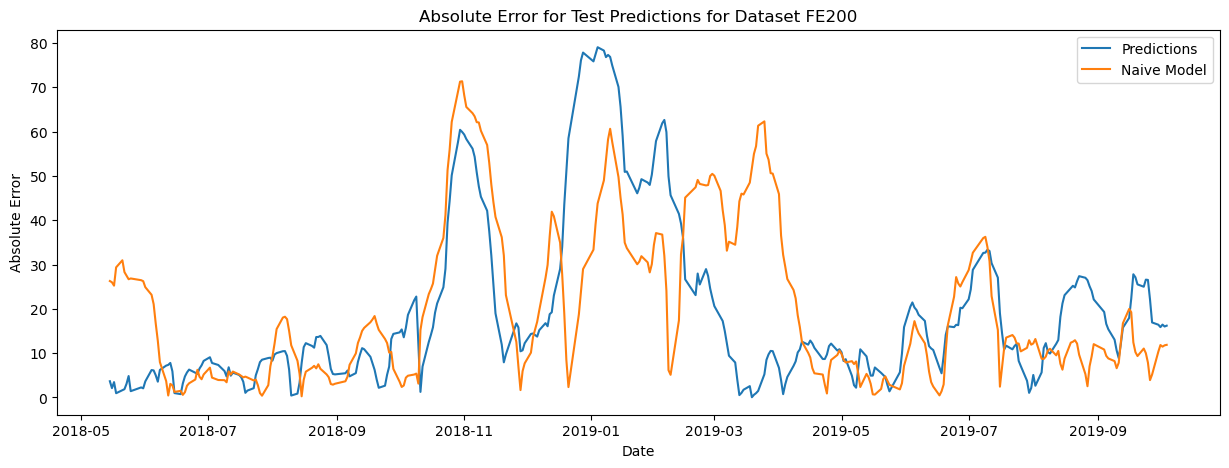

In [141]:
# compare simple model that predicts target as today's value to best model

# last 30 values of Y_val + all except last 30 values of Y_test to generate predictions assuming today +30 days is todays value
simple_today_preds = list(Y_val[-30:]) + list(Y_test[:-30])

simple_today_mae = mean_absolute_error(Y_test, simple_today_preds)
print('Test MAE for Naive Model:', simple_today_mae)
print('Test MAE for Best Model:', test_mae)

plt.figure(figsize=(15,5))
plt.plot(test_dates, abs(test_predictions - Y_test), label='Predictions')
plt.plot(test_dates, abs(simple_today_preds - Y_test), label='Naive Model')

plt.title(f'Absolute Error for Test Predictions for Dataset {dataset_names[best_id]}')
plt.xlabel('Date')
plt.ylabel('Absolute Error')
plt.legend()
plt.show()


Test MAPE for Naive Model: 40.126532316207886
Test MAPE for Best Model: 32.59274661540985


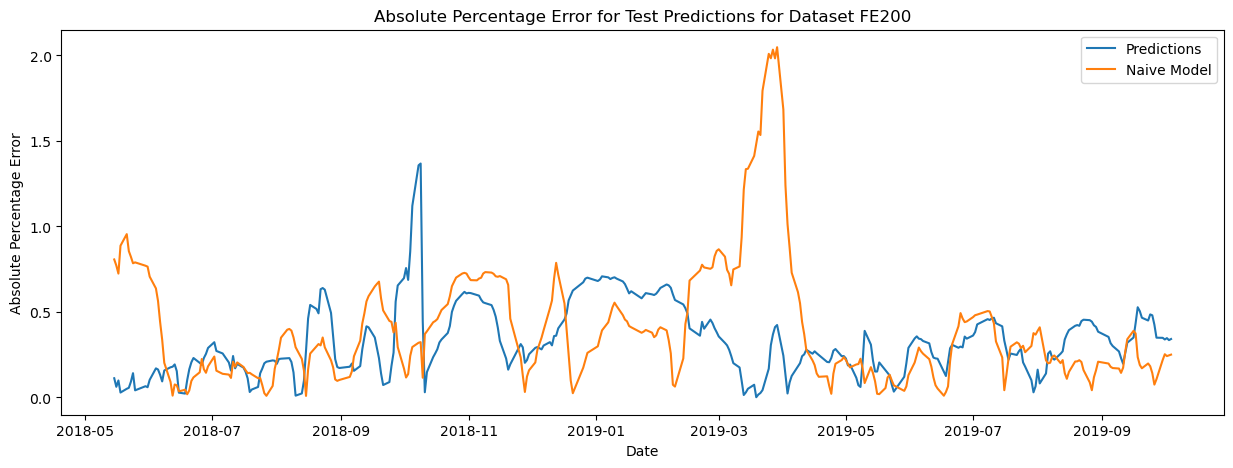

In [142]:
# same for MAPE

simple_today_mape = mean_absolute_percentage_error(Y_test, simple_today_preds)
print('Test MAPE for Naive Model:', simple_today_mape)
print('Test MAPE for Best Model:', test_mape)

plt.figure(figsize=(15,5))
plt.plot(test_dates, abs(test_predictions - Y_test) / Y_test, label='Predictions')
plt.plot(test_dates, abs(simple_today_preds - Y_test) / Y_test, label='Naive Model')
plt.title(f'Absolute Percentage Error for Test Predictions for Dataset {dataset_names[best_id]}')
plt.xlabel('Date')
plt.ylabel('Absolute Percentage Error')
plt.legend()
plt.show()

The best model also seems to outperform the simple today model for the test period.